In [89]:
# Change the Directory
import os
os.chdir("C:\\Users\\datam\\OneDrive\\Desktop\\python") # change as needed

# Verify the change
os.getcwd()

'C:\\Users\\datam\\OneDrive\\Desktop\\python'

In [90]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from boruta import BorutaPy
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
# Set random seed for reproducibility
np.random.seed(1066)

## 1. RPART (Decision Tree) Section

In [92]:
# Load data (assuming sim_df.csv exists)
sim_df = pd.read_csv("sim_df.csv", dtype=str)
sim_df['y'] = sim_df['y']
sim_df.shape

(10000, 17)

In [93]:
sim_df['y'].value_counts()

y
0    7072
1    2928
Name: count, dtype: int64

In [96]:
# Split data
X = sim_df.drop('y', axis=1)
y = sim_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Fit decision tree
y.target = ["bad" if label == 1 else "good" for label in y_train]

dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [97]:
# Get complexity parameter information (similar to cptable)
# Need to put this into the df
print("Feature importances:", dt.feature_importances_)

Feature importances: [0.4399593  0.33111389 0.         0.13954066 0.07663088 0.00701867
 0.00573661 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


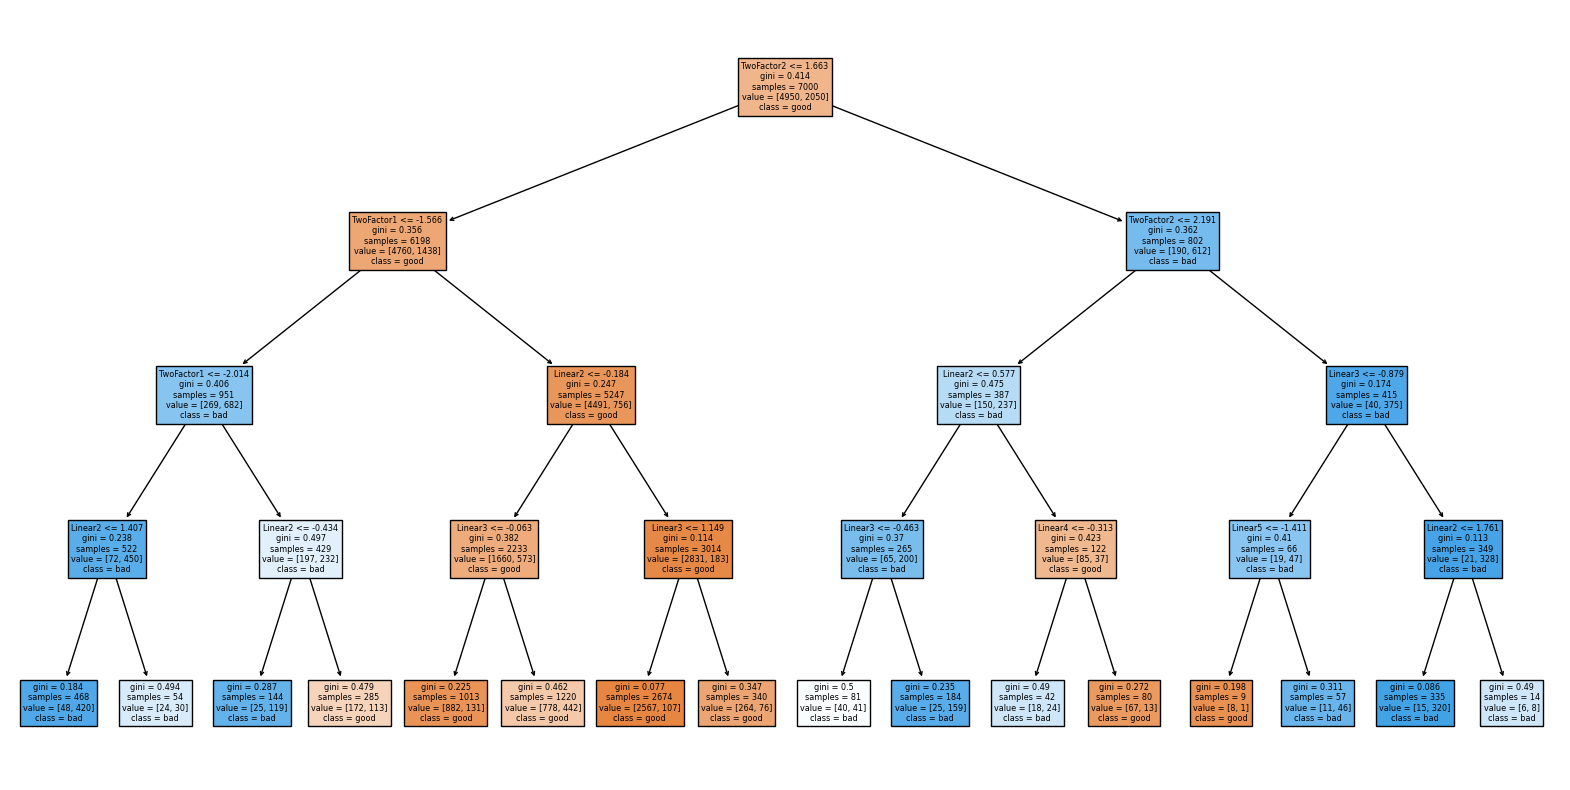

In [98]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns, class_names=['good','bad'], filled=True)
plt.show()

In [99]:
feature_names = X.columns.tolist()
target_names = ['0', '1']

In [100]:
from supertree import SuperTree

In [101]:
# Create an interactive visualization using SuperTree
# Initialize supertree
super_tree = SuperTree(dt, X_train, y_train, feature_names, target_names)

In [102]:
# Display the interactive visualization
# Not working as advertised, but the tutorials worked perfect in my python playground
tree_viz.show_tree()

In [103]:
# Predictions and evaluation
dt_probs = dt.predict_proba(X_test)[:, 1]
y_test_num = (y_test == '1').astype(int)
print("Decision Tree AUC:", roc_auc_score(y_test_num, dt_probs))
print("Decision Tree Log Loss:", log_loss(y_test_num, dt_probs))

Decision Tree AUC: 0.8542345189456801
Decision Tree Log Loss: 0.4063891755456181


In [104]:
# Improvement suggestion: Add cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(dt, X, y, cv=5, scoring='roc_auc')
print("Cross-validated AUC:", cv_scores.mean())

Cross-validated AUC: 0.8544214781091604


## Random Forest

In [105]:
santander = pd.read_csv("santander_treated.csv")
X = santander.drop('y', axis=1)
y = santander['y']
X.shape

(71192, 123)

In [121]:
santander.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var40_comer_ult1,imp_op_var40_efect_ult1,imp_op_var40_efect_ult1_isNA,imp_op_var40_efect_ult3_isNA,imp_op_var40_ult1,imp_op_var41_efect_ult1_isNA,imp_op_var41_efect_ult3,...,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult1_isNA,saldo_medio_var17_hace2,saldo_medio_var33_ult1,saldo_medio_var33_ult1_isNA,saldo_medio_var44_hace2,saldo_medio_var44_hace3,var38,var3_isNA,y
0,2,23,0.0,0.0,0.0,0,0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,39205.170000,0,0
1,2,34,0.0,0.0,0.0,0,0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,49278.030000,0,0
2,2,23,0.0,0.0,0.0,0,0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,67333.770000,0,0
3,2,37,0.0,0.0,0.0,0,0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,64007.970000,0,0
4,2,39,0.0,0.0,0.0,0,0,0.0,0,0.0,...,0.0,0,0.0,0.0,0,0.0,0.0,117310.979016,0,0


In [106]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1966)
X_train.shape

(56953, 123)

In [107]:
# Remove near-zero variance features (improvement: using VarianceThreshold)
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)  # More flexible than nearZeroVar in R
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)
X_train.shape

(56953, 90)

In [108]:
# Random Forest
# provide description of class_weight
rf = RandomForestClassifier(n_estimators=200, 
                           class_weight={0: 1, 1: 3},  # Similar to sampsize adjustment
                           random_state=1999)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 3}, n_estimators=200,
                       random_state=1999)

In [124]:
# Feature importance
# Feature importance DataFrame with index
feat_importance = pd.DataFrame({
    'index': np.where(selector.get_support())[0],  # Get the index positions
    'feature': X.columns[selector.get_support()].tolist(),
    'importance': rf.feature_importances_
})
print(feat_importance.sort_values('index', ascending=True))

    index                  feature  importance
0       0                     var3    0.006376
1       1                    var15    0.199244
2       2       imp_ent_var16_ult1    0.005924
3       3  imp_op_var40_comer_ult1    0.000273
4       4  imp_op_var40_efect_ult1    0.000648
..    ...                      ...         ...
85    116  saldo_medio_var17_hace2    0.000031
86    117   saldo_medio_var33_ult1    0.000016
87    119  saldo_medio_var44_hace2    0.000019
88    120  saldo_medio_var44_hace3    0.000004
89    121                    var38    0.344635

[90 rows x 3 columns]


In [126]:
feature_names = feat_importance['feature'].to_list()
feature_names

['var3',
 'var15',
 'imp_ent_var16_ult1',
 'imp_op_var40_comer_ult1',
 'imp_op_var40_efect_ult1',
 'imp_op_var40_ult1',
 'imp_op_var41_efect_ult3',
 'imp_sal_var16_ult1',
 'ind_var24_0',
 'ind_var37_0',
 'num_var4',
 'num_var5_0',
 'num_var12_0',
 'num_var14_0',
 'num_var25_0',
 'num_op_var40_hace2',
 'num_op_var40_hace3',
 'num_op_var40_ult1',
 'num_op_var41_hace2',
 'num_op_var41_hace3',
 'num_var37_med_ult2',
 'saldo_var1',
 'saldo_var5',
 'saldo_var8',
 'saldo_var14',
 'saldo_var20',
 'saldo_var25',
 'saldo_var34',
 'saldo_var37',
 'saldo_var44',
 'var36',
 'delta_imp_compra_var44_1y3',
 'delta_imp_reemb_var13_1y3',
 'delta_imp_trasp_var17_in_1y3',
 'delta_imp_venta_var44_1y3',
 'imp_aport_var13_ult1',
 'imp_aport_var17_hace3',
 'imp_aport_var17_ult1',
 'imp_aport_var33_ult1',
 'imp_var7_recib_ult1',
 'imp_compra_var44_hace3',
 'imp_reemb_var13_ult1',
 'imp_reemb_var17_ult1',
 'imp_reemb_var33_ult1',
 'imp_trans_var37_ult1',
 'imp_trasp_var17_in_ult1',
 'imp_trasp_var33_in_ult1',
 

In [122]:
# Reduced feature set based on the median importance value
top_features = feat_importance[feat_importance['importance'] > feat_importance['importance'].median()]
X_train_reduced = X_train[:, top_features.index]
X_test_reduced = X_test[:, top_features.index]
top_features.index

Index([ 0,  1,  2,  6,  8,  9, 10, 11, 12, 13, 14, 18, 19, 20, 22, 23, 26, 28,
       30, 44, 48, 49, 50, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 69, 70, 71,
       73, 74, 75, 76, 77, 78, 79, 81, 89],
      dtype='int64')

In [112]:
# Second RF with reduced features
rf2 = RandomForestClassifier(n_estimators=200, 
                            class_weight={0: 1, 1: 3},
                            random_state=567)
rf2.fit(X_train_reduced, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 3}, n_estimators=200,
                       random_state=567)

In [113]:
# Evaluation
# add train set evaluation to review bias/variance tradeoff
rf_probs = rf.predict_proba(X_test)[:, 1]
#y_test_num = (y_test == '1').astype(int)
print("RF AUC:", roc_auc_score(y_test, rf_probs))
print("RF Log Loss:", log_loss(y_test, rf_probs))

RF AUC: 0.7605286493607606
RF Log Loss: 0.2832373219262857


In [114]:
# Probability correction function
def corrected_prob(result, population_fraction, sample_fraction):
    return 1/(1+(1/population_fraction-1)/(1/sample_fraction-1)*(1/result-1))

In [115]:
# Apply correction
rf_probs_corrected = corrected_prob(rf_probs, 0.04, 0.33)
print("Corrected RF AUC:", roc_auc_score(y_test, rf_probs_corrected))

Corrected RF AUC: 0.7605286493607606


C:\Users\datam\AppData\Local\Temp\ipykernel_51264\999931977.py:3: RuntimeWarning: divide by zero encountered in divide
  return 1/(1+(1/population_fraction-1)/(1/sample_fraction-1)*(1/result-1))


## XgBoost

In [116]:
# Parameter grid
param_grid = {
    'n_estimators': [100],
    'colsample_bytree': [1],
    'min_child_weight': [1],
    'learning_rate': [0.1, 0.3, 0.5],
    'gamma': [0.25, 0.5],
    'subsample': [1],
    'max_depth': [3]
}

In [127]:
# Grid search with cross-validation
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error')
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='error', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [1], 'gamma': [0.25, 0.5],
                         'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [3],
                         'min_child_weight': [1], 'n_estimators': [100],
                         'subsample': [1]},
             scoring='roc_auc')

In [129]:
# Best model
best_xgb = grid_search.best_estimator_
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]
print("XGBoost AUC:", roc_auc_score(y_test, xgb_probs))
print("XGBoost Log Loss:", log_loss(y_test, xgb_probs))

XGBoost AUC: 0.8408908779637683
XGBoost Log Loss: 0.13202276215804473


In [130]:
# Ensure feature names are assigned
# Assign feature names to the booster (this ensures names appear in plots)
best_xgb.get_booster().feature_names = feature_names

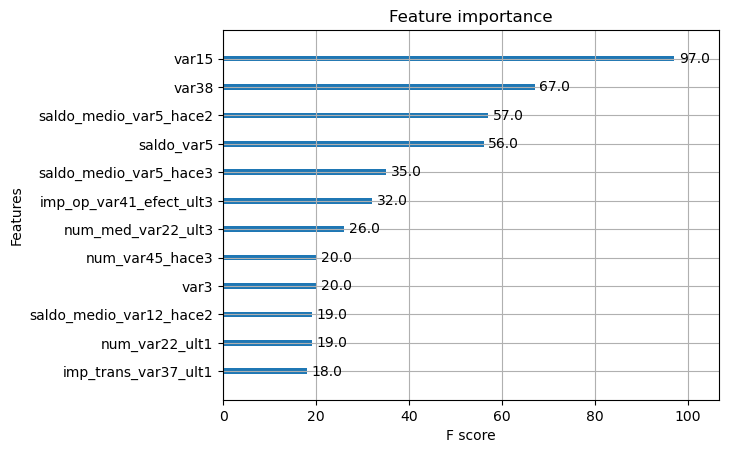

In [133]:
# Feature importance plot

xgb.plot_importance(best_xgb, max_num_features = 12)
plt.show()

In [136]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (1)
y_probs = best_xgb.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)  # Compute AUC score


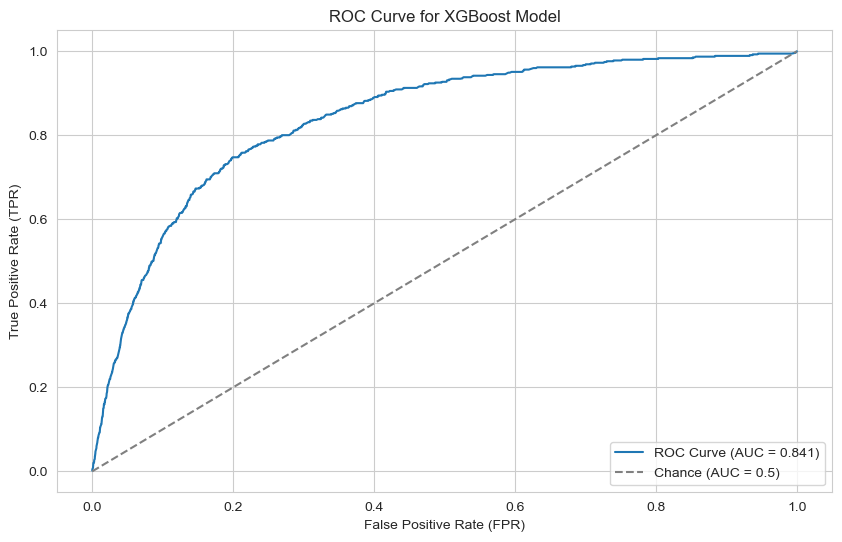

In [148]:
# Create an ROC curve plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')

# Plot the diagonal reference line
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="gray", label="Chance (AUC = 0.5)")

# Customize the plot
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for XGBoost Model")
plt.legend(loc="lower right")
plt.show()


In [140]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (1)
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Create a DataFrame and sort by probability (descending)
lift_df = pd.DataFrame({"probability": y_probs, "actual": y_test})
lift_df = lift_df.sort_values(by="probability", ascending=False)

# Compute cumulative true positives
lift_df["cumulative_positives"] = lift_df["actual"].cumsum()

# Compute percentage of total positives captured
total_positives = lift_df["actual"].sum()
lift_df["percent_positive"] = lift_df["cumulative_positives"] / total_positives

# Compute percentage of total data used (bins)
lift_df["percent_data"] = np.linspace(1 / len(lift_df), 1, len(lift_df))

# Compute Lift (model performance compared to random)
lift_df["lift"] = lift_df["percent_positive"] / lift_df["percent_data"]


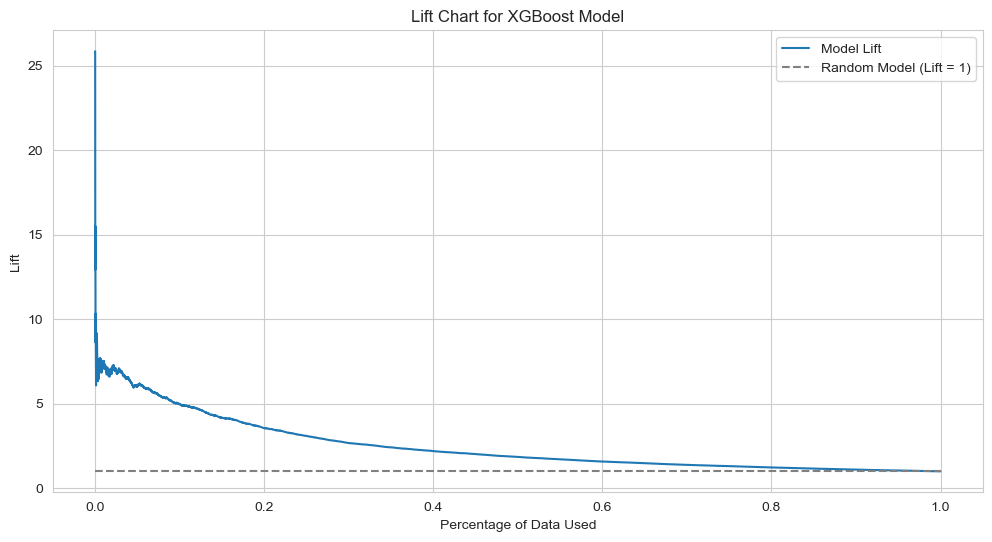

In [146]:
plt.figure(figsize=(12, 6))

# Plot Lift Curve
sns.lineplot(x=lift_df["percent_data"], y=lift_df["lift"], label="Model Lift")

# Baseline (random model) - Lift = 1
sns.lineplot(x=[0, 1], y=[1, 1], linestyle="--", color="gray", label="Random Model (Lift = 1)")

# Customize the plot
plt.xlabel("Percentage of Data Used")
plt.ylabel("Lift")
plt.title("Lift Chart for XGBoost Model")
plt.legend(loc="upper right")
plt.show()


### Interpretation of the Lift Chart
Lift > 1 → Model is performing better than random chance.
Higher Lift Early On → Model effectively ranks positive instances first.
If Lift Quickly Drops to 1 → Model’s advantage diminishes as more data is included.

In [143]:
# Create a DataFrame for plotting
kde_df = pd.DataFrame({"Probability": y_probs, "Actual": y_test})


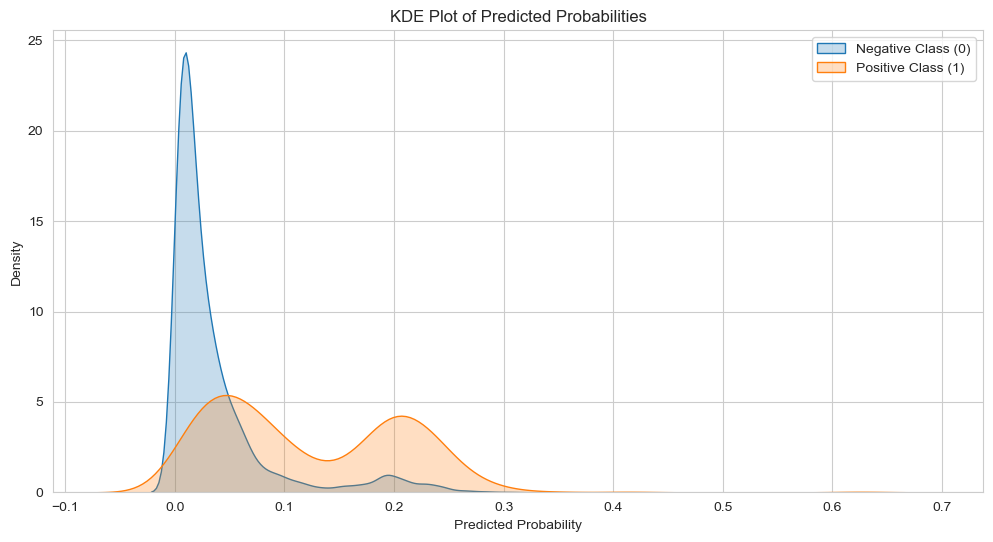

In [145]:
plt.figure(figsize=(12, 6))

# Plot KDE for class 0 (negative cases)
sns.kdeplot(data=kde_df[kde_df["Actual"] == 0], x="Probability", label="Negative Class (0)", fill=True)

# Plot KDE for class 1 (positive cases)
sns.kdeplot(data=kde_df[kde_df["Actual"] == 1], x="Probability", label="Positive Class (1)", fill=True)

# Customize the plot
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("KDE Plot of Predicted Probabilities")
plt.legend()
plt.show()
